In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from scipy import interp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import plotly.express as px
from sklearn.decomposition import PCA
import umap
import matplotlib
import operator
import collections
import networkx as nx
from networkx.algorithms import bipartite
from fa2 import ForceAtlas2
from scipy.stats import hypergeom

/Users/giulia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/giulia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/giulia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.2

In [2]:
# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"

# Path 2 Data Dumps

In [3]:
# path to new data
path_update='/data/sars-busters-consolidated/Database files/'

# DrugBank Data

In [4]:
#Updated Database for DrugBank
DB_df_clean_PubChem_Fetch=joblib.load(path_update+'DB_df_clean_PubChem_Fetch_Updated_Sequence_all.pkl')
print('DrugBank Original File: '+str(DB_df_clean_PubChem_Fetch.shape[0]))
# Binding Info for DrugBank Updated
bindingdictDBclean=joblib.load(path_update+'bindingdictDBclean_Updated_Sequence_all.pkl')
print('DrugBank related compounds and targets from BD: '+str(len(bindingdictDBclean)))

DrugBank Original File: 25579
DrugBank related compounds and targets from BD: 19097


# Get Data Structure dictDB

In [5]:
# there are redundant pairs that we need to merge, keeping the experimental annotations
counter_interactionsDB=collections.Counter(bindingdictDBclean['pair'])
counter_interactionsDBkey=sorted(counter_interactionsDB, key=counter_interactionsDB.get, reverse=True)
pairDBselection=[k for k in counter_interactionsDBkey if (counter_interactionsDB[k]>1)]

dictupdateDB={}
for k in pairDBselection:
    tempdict = collections.defaultdict(list)
    for key, val in [(z,t) for v in bindingdictDBclean[bindingdictDBclean['pair']==k]['constant'] for z,t in v.items()]:
        tempdict[key].append(val)
    
    dictupdateDB[k]={key: min(val) for key, val in tempdict.items()}

dictDB={k:v for k in (set(counter_interactionsDBkey)-set(pairDBselection)) for v in bindingdictDBclean[bindingdictDBclean['pair']==k]['constant'] }
dictDB.update(dictupdateDB)
print('Updated Length of DrugBank-related interactions from BindingDB')
print(len(dictDB))

Updated Length of DrugBank-related interactions from BindingDB
19094


In [6]:
# active pairs from DrugBank-related drugs and target
tr=10**3
labelactiveDB={k for k,v in dictDB.items() if (sum(np.array(list(v.values()))<=tr)>0)}
print('active pairs from DrugBank related drugs and target')
print(len(labelactiveDB))

# pairs from DrugBank
DBset={(c,t) for c,t in DB_df_clean_PubChem_Fetch[['drug_inchi_key','target_aa_sequence']].values}
print('pairs from DrugBank')
print(len(DBset))


active pairs from DrugBank related drugs and target
5838
pairs from DrugBank
25373


# NDM data

In [7]:
#Updated Database for NDM
NDMtofilterfromDTC=joblib.load(path_update+'NDMinDTCtofilter_w_aaseq_Updated_Sequence.pkl')
print('NDM from DTC: '+str(len(NDMtofilterfromDTC)))
# Binding Info for NDM
bindingdictNDMclean=joblib.load(path_update+'bindingdictNDMclean_Updated_Sequence_all.pkl')
print('NDM from BD: '+str(len(bindingdictNDMclean)))

NDM from DTC: 6198
NDM from BD: 5986


# Get Data Structure dictNDM

In [9]:
counter_interactionsNDM=collections.Counter(bindingdictNDMclean['pair'])
counter_interactionsNDMkey=sorted(counter_interactionsNDM, key=counter_interactionsNDM.get, reverse=True)
pairNDMselection=[k for k in counter_interactionsNDMkey if (counter_interactionsNDM[k]>1)]

dictupdateNDM={}
for k in pairNDMselection:
    tempdict = collections.defaultdict(list)
    for key, val in [(z,t) for v in bindingdictNDMclean[bindingdictNDMclean['pair']==k]['constant'] for z,t in v.items()]:
        tempdict[key].append(val)
    
    dictupdateNDM[k]={key: min(val) for key, val in tempdict.items()}

dictNDM={k:v for k in (set(counter_interactionsNDMkey)-set(pairNDMselection)) for v in bindingdictNDMclean[bindingdictNDMclean['pair']==k]['constant'] }
dictNDM.update(dictupdateDB)
print('Updated Length of NDM from BindingDB')
print(len(dictNDM))

Updated Length of NDM from BindingDB
5985


In [10]:
# active pairs for all compounds in NDM
tr=10**3
labelactiveNDM={k for k,v in dictNDM.items() if (sum(np.array(list(v.values()))<=tr)>0)}
print('Pairs from Binding ')
print(len(labelactiveNDM))

NDMgraph=NDMtofilterfromDTC[NDMtofilterfromDTC['standard_value']<=tr]
NDMsetfromDTCactive={(c,t) for c,t in NDMgraph[['InChi','aaseq']].values}
print('Pairs from DTC')
print(len(NDMsetfromDTCactive))

print('Intersections between the 2')
print(len(labelactiveNDM&NDMsetfromDTCactive))

NDMnetworklabel=(labelactiveNDM|NDMsetfromDTCactive)
print('Total pairs contributing to the network')
print(len(NDMnetworklabel))

Pairs from Binding 
1260
Pairs from DTC
699
Intersections between the 2
419
Total pairs contributing to the network
1540


# Global Network Comprising all the interactions and corrections

In [11]:
# import whole binding DB to remove potential weak binders
bindingdictWholeBindingDB=joblib.load(path_update+'bindingdictWholeBindingDB_Updated_Sequence.pkl')
print('Length Whole BindingDB')
print(len(bindingdictWholeBindingDB))
counter_interactionsWDB=collections.Counter(bindingdictWholeBindingDB['pair'])
counter_interactionsWDBkey=sorted(counter_interactionsWDB, key=counter_interactionsWDB.get, reverse=True)
pairWDBselection=[k for k in counter_interactionsWDBkey if (counter_interactionsWDB[k]>1)]
print('Pairs affected')
print(len(pairWDBselection))
dictupdateWDB={}
for k in pairWDBselection:
    tempdict = collections.defaultdict(list)
    for key, val in [(z,t) for v in bindingdictWholeBindingDB[bindingdictWholeBindingDB['pair']==k]['reaction_constant'] for z,t in v.items()]:
        tempdict[key].append(val)
    
    dictupdateWDB[k]={key: min(val) for key, val in tempdict.items()}

bindingdictWholeBindingDB=bindingdictWholeBindingDB[~bindingdictWholeBindingDB['pair'].isin(pairWDBselection)]
print('Length Whole BindingDB No Repetitions')
print(len(bindingdictWholeBindingDB))

data=[{'pair': k, 'reaction_constant': v} for k,v in dictupdateWDB.items()]
bindingdictWholeBindingDB = bindingdictWholeBindingDB.append(data, ignore_index=True)
print('Length Updated Whole BindingDB')
print(len(bindingdictWholeBindingDB))

# inactive pairs to check
tr=10**6
labelinactiveBindingDB={k for k,v in bindingdictWholeBindingDB[['pair', 'reaction_constant']].values if (sum(np.array(list(v.values()))>=tr)==len(v.values()))}
print('inactive pairs to check')
print(len(labelinactiveBindingDB))

print('interactions to remove from DrugBank')
print(len(DBset&labelinactiveBindingDB))

print('interactions to remove from NDM')
print(len(labelinactiveBindingDB&NDMnetworklabel))

TotalNetwork=((DBset|labelactiveDB)|NDMnetworklabel)-labelinactiveBindingDB
print('Total interactions contributing to the Network')
print(len(TotalNetwork))

Length Whole BindingDB
1376181
Pairs affected
16
Length Whole BindingDB No Repetitions
1376149
Length Updated Whole BindingDB
1376165
inactive pairs to check
11849
interactions to remove from DrugBank
54
interactions to remove from NDM
0
Total interactions contributing to the Network
30813


In [62]:
Totallinks=pd.DataFrame.from_dict({'InChiKey': [k[0] for k in TotalNetwork], 'aaseq':[k[1] for k in TotalNetwork]})
#bipartite network
set_compoundsTotal=set(Totallinks['InChiKey'])
set_proteinsTotal=set(Totallinks['aaseq'])
BTotal = nx.Graph()
BTotal.add_nodes_from(set_compoundsTotal, bipartite=0)
BTotal.add_nodes_from(set_proteinsTotal, bipartite=1)
BTotal.add_edges_from(Totallinks[['InChiKey', 'aaseq']].values)

# colormap
clistTotal=np.zeros((len(BTotal),3));
count=0
for n in BTotal.nodes():
    if n in set_compoundsTotal:
        clistTotal[count,:]=np.array([117,112,179])/255
    else:
        clistTotal[count,:]=np.array([217,95,2])/255
    
    count+=1
    
degreelistTotal=np.array([BTotal.degree[k] for k in BTotal])

# statistics
print('Number of Nodes')
print(len(BTotal.nodes))
print('Number of Links')
print(len(BTotal.edges))
print('Number of Compounds')
print(len(set_compoundsTotal))
print('Number of Proteins')
print(len(set_proteinsTotal))
positionsTotal = forceatlas2.forceatlas2_networkx_layout(BTotal, pos=None, iterations=2000)

Number of Nodes
13215
Number of Links
30813
Number of Compounds
8111
Number of Proteins
5104


100%|██████████| 2000/2000 [06:54<00:00,  4.82it/s] 

BarnesHut Approximation  took  79.20  seconds
Repulsion forces  took  322.33  seconds
Gravitational forces  took  0.81  seconds
Attraction forces  took  0.76  seconds
AdjustSpeedAndApplyForces step  took  4.03  seconds


In [83]:
listNodes=list(set_compoundsTotal|set_proteinsTotal)
NodesTypes=['Chemical' if k in set_compoundsTotal else 'Protein' for k in listNodes]
IsDrug=[True if k in set_drugs else False for k in listNodes ]
IsNDM=[True if k in set_compounds else False for k in listNodes]
IsDrugTarget=[True if k in set_targets else False for k in listNodes]
IsNDMTarget=[True if k in set_proteins else False for k in listNodes]

NodesTable=pd.DataFrame.from_dict({'Label': listNodes, 'Type': NodesTypes, 'IsDrug': IsDrug, 'IsNDM': IsNDM, 'IsDrugTarget': IsDrugTarget, 'IsNDMTarget': IsNDMTarget})

In [ ]:
# For Gephi-->Node Table
NodesTable['Type2']=NodesTable['Type']
NodesTable['Type2'][(NodesTable['Type2']=='Chemical')&(NodesTable['IsDrug']==True)&(NodesTable['IsNDM']==False)]='Just DrugBank'
NodesTable['Type2'][(NodesTable['Type2']=='Chemical')&(NodesTable['IsDrug']==False)&(NodesTable['IsNDM']==True)]='Just NDM'
NodesTable['Type2'][(NodesTable['Type2']=='Chemical')&(NodesTable['IsDrug']==True)&(NodesTable['IsNDM']==True)]='Overlap'
NodesTable['Id']=[i+1 for i in NodesTable.index]

# For Gephi--> EdgeTable
mappingNodes={i:j for (i,j) in NodesTable[['Label','Id']].values}
EdgesTable=pd.DataFrame.from_dict({'Source':[mappingNodes[r] for r in Totallinks['InChiKey']], 'Target':[mappingNodes[r] for r in Totallinks['aaseq']], 'Type':['Undirected']*Totallinks.shape[0]})

NodesTable.to_csv(path_update+'WholeNetworkNodesTable.csv')

EdgesTable.to_csv(path_update+'WholeNetworkEdgesTable.csv') ## This is positive links file as /data/sars-busters-consolidated/interactions/dataset_1.csv

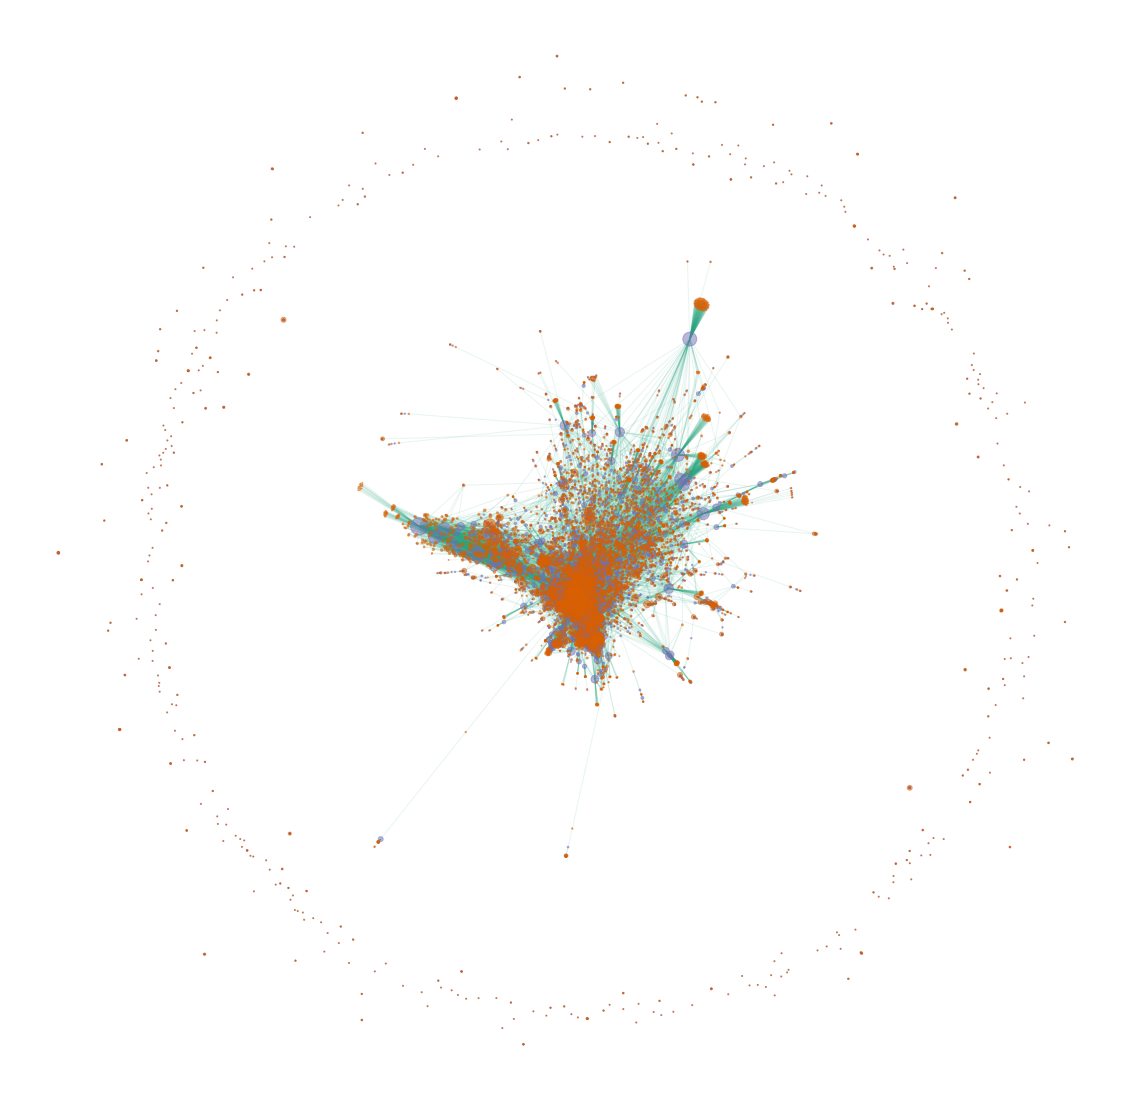

In [101]:
plt.figure(figsize = (20, 20))
nx.draw_networkx_nodes(BTotal, positionsTotal, node_size=degreelistTotal, with_labels=False, node_color=clistTotal, alpha=0.5)
nx.draw_networkx_edges(BTotal, positionsTotal, edge_color=np.array([27,158,119])/255, alpha=0.1)
plt.axis('off');

Number of Connected Components
387
Size
[12079, 27, 25, 15, 11, 10, 10, 9, 9, 9, 9, 9, 9, 8, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

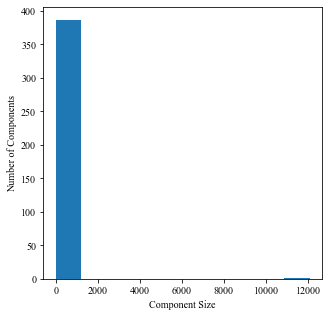

In [55]:
# Connected components
connect_components_list = [len(n) for n in nx.connected_components(BTotal)]
connect_components_list.sort(reverse=True)
print('Number of Connected Components')
print(len(connect_components_list))
print('Size')
print(connect_components_list)
plt.figure(figsize = (5, 5))
plt.hist(connect_components_list)
plt.xlabel('Component Size');
plt.ylabel('Number of Components');

In [56]:
# giant cluster
subgraphsTotal = sorted(nx.connected_components(BTotal), key=len, reverse=True)
Total_major = BTotal.subgraph(subgraphsTotal[0])
print('Giant Cluster Size')
print(len(Total_major))
print('Is connected?')
print(nx.is_connected(Total_major))
# average degree
print('Average Degree Giant Cluster')
print(np.mean(np.array([n[1] for n in Total_major.degree])))

clistTotal_major=np.zeros((len(Total_major),3));
count=0
for n in Total_major.nodes():
    if n in set_compoundsTotal:
        clistTotal_major[count,:]=np.array([117,112,179])/255
    else:
        clistTotal_major[count,:]=np.array([217,95,2])/255
    
    count+=1
    
    
degreelistTotal_major=np.array([Total_major.degree[k] for k in Total_major])

bottom_nodesTotal, top_nodesTotal = bipartite.sets(Total_major)
print('Number of Nodes')
print(len(Total_major.nodes))
print('Number of Links')
print(len(Total_major.edges))
print('Number of Compounds')
print(len(bottom_nodesTotal))
print('Number of Proteins')
print(len(top_nodesTotal))

positionsTotal_major = forceatlas2.forceatlas2_networkx_layout(Total_major, pos=None, iterations=2000)

Giant Cluster Size
12079
Is connected?
True
Average Degree Giant Cluster
4.972762645914397
Number of Nodes
12079
Number of Links
30033
Number of Compounds
7468


100%|██████████| 2000/2000 [07:23<00:00,  4.51it/s]

Number of Proteins
4611
BarnesHut Approximation  took  189.32  seconds
Repulsion forces  took  241.35  seconds
Gravitational forces  took  0.85  seconds
Attraction forces  took  0.74  seconds
AdjustSpeedAndApplyForces step  took  3.71  seconds


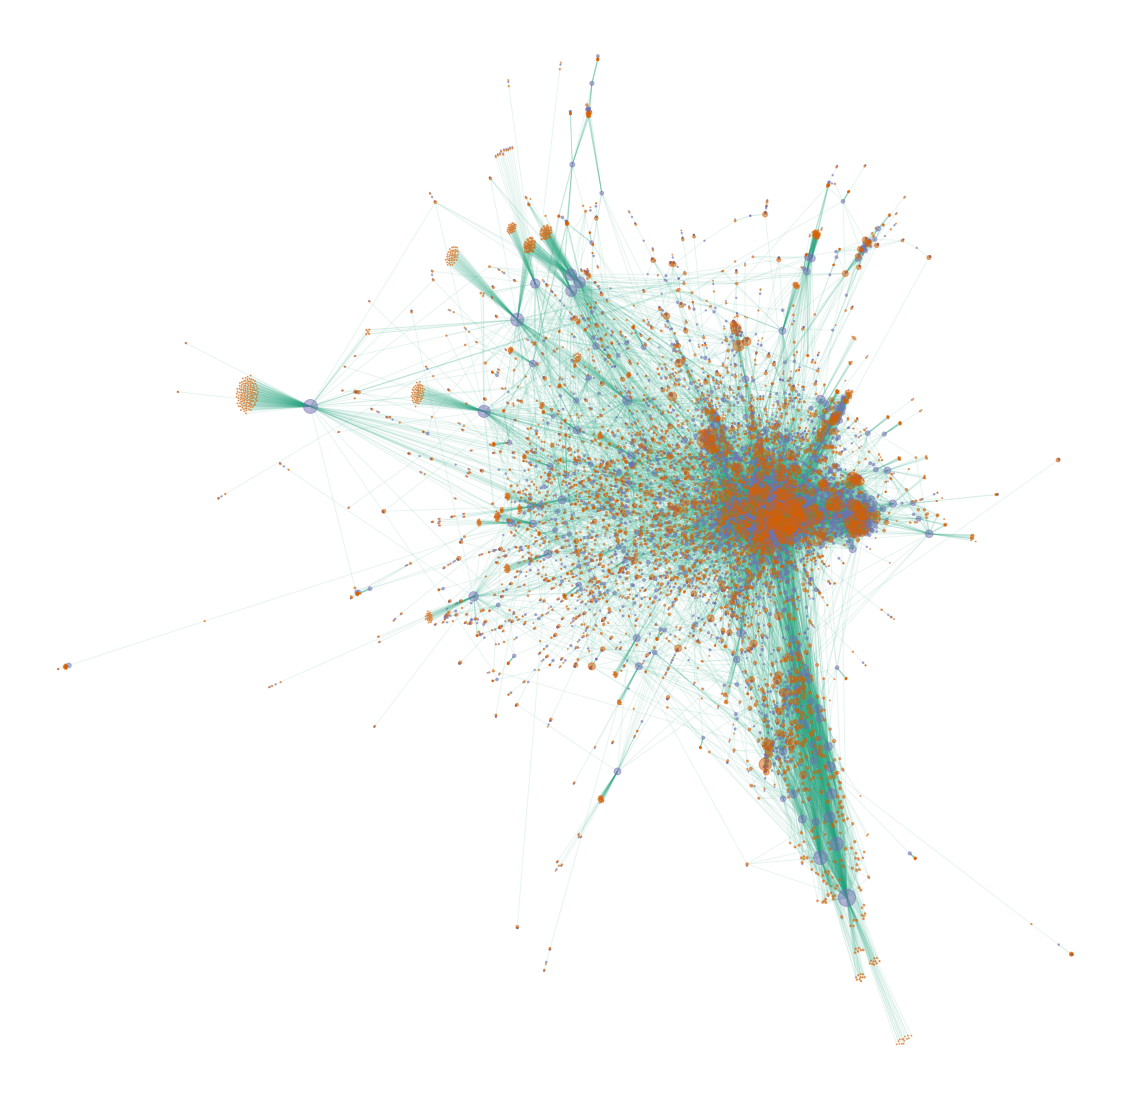

In [57]:
plt.figure(figsize = (20, 20))
nx.draw_networkx_nodes(Total_major, positionsTotal_major, node_size=degreelistTotal_major, with_labels=False, node_color=clistTotal_major, alpha=0.5)
nx.draw_networkx_edges(Total_major, positionsTotal_major, edge_color=np.array([27,158,119])/255, alpha=0.1)
plt.axis('off');

In [58]:
# shortest path bipartite network
shortest_path_bpTotal=dict(nx.all_pairs_shortest_path(Total_major))
joblib.dump(shortest_path_bpTotal,path_update+'shortest_path_bp_Total.pkl')

['shortest_path_bp_Total.pkl']

Text(0, 0.5, 'Count')

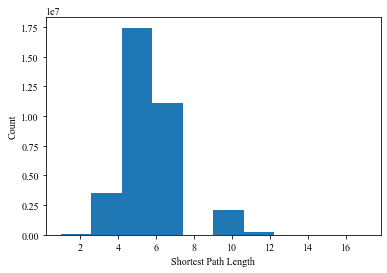

In [59]:
#length pathways
lenpath_bpTotal=[len(shortest_path_bpTotal[d][g])-1 for d in bottom_nodesTotal for g in top_nodesTotal]
plt.hist(lenpath_bpTotal)
plt.xlabel('Shortest Path Length')
plt.ylabel('Count')